In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import mobilenet
from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image


#### defining train and validation sets

In [17]:
image_size = (224, 224)
batch_size = 32

train = tf.keras.preprocessing.image_dataset_from_directory(
    "./Data/data_demage/training/",
    image_size=image_size,
    batch_size=batch_size,
)
val = tf.keras.preprocessing.image_dataset_from_directory(
    "./Data/data_demage/validation/",
    image_size=image_size,
    batch_size=batch_size,
)


Found 1840 files belonging to 2 classes.
Found 460 files belonging to 2 classes.


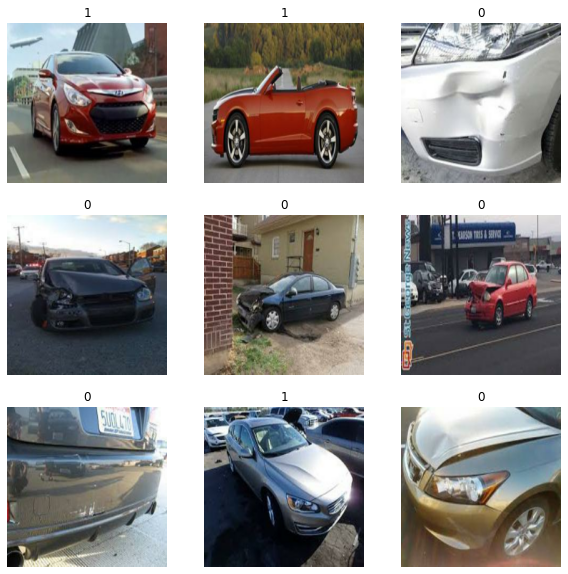

In [18]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [19]:
new_input = keras.Input(shape=(224, 224, 3))
base_model = mobilenet.MobileNet(include_top=False, 
                            input_tensor=new_input, 
                            pooling='max', 
                            weights='imagenet')

In [20]:
# freeze base model to use the pre-trained imagenet weights!
base_model.trainable=False

In [29]:
augmented_train = train.map(
  lambda x, y: (mobilenet.preprocess_input(x), y))
augmented_val = val.map(
  lambda x, y: (mobilenet.preprocess_input(x), y))

In [7]:
model=keras.Sequential()
model.add(base_model)
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1024)              3228864   
_________________________________________________________________
dense (Dense)                (None, 100)               102500    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 3,331,465
Trainable params: 102,601
Non-trainable params: 3,228,864
_________________________________________________________________


In [8]:
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.binary_crossentropy,
             metrics=[keras.metrics.binary_accuracy]
             )

In [9]:
callback=keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [10]:
results_freeze = model.fit(augmented_train, 
                    epochs=15, 
                    validation_data=augmented_val,
                    verbose=1,
                    callbacks=[callback],
                    
                   )

Epoch 1/15
58/58 [==============================] - 26s 426ms/step - loss: 1.1763 - binary_accuracy: 0.7114 - val_loss: 0.3446 - val_binary_accuracy: 0.8522
Epoch 2/15
58/58 [==============================] - 27s 470ms/step - loss: 0.4338 - binary_accuracy: 0.8060 - val_loss: 0.3296 - val_binary_accuracy: 0.8804
Epoch 3/15
58/58 [==============================] - 33s 567ms/step - loss: 0.3952 - binary_accuracy: 0.8212 - val_loss: 0.2869 - val_binary_accuracy: 0.8848
Epoch 4/15
58/58 [==============================] - 30s 524ms/step - loss: 0.3542 - binary_accuracy: 0.8391 - val_loss: 0.3015 - val_binary_accuracy: 0.8761
Epoch 5/15
58/58 [==============================] - 30s 512ms/step - loss: 0.3444 - binary_accuracy: 0.8592 - val_loss: 0.2319 - val_binary_accuracy: 0.9022
Epoch 6/15
58/58 [==============================] - 30s 518ms/step - loss: 0.3376 - binary_accuracy: 0.8473 - val_loss: 0.2636 - val_binary_accuracy: 0.9065
Epoch 7/15
58/58 [==============================] - 27s 46

In [11]:
# unfreeze base model!
base_model.trainable=True

In [12]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
             loss=keras.losses.binary_crossentropy,
             metrics=[keras.metrics.binary_accuracy]
             )

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1024)              3228864   
_________________________________________________________________
dense (Dense)                (None, 100)               102500    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 3,331,465
Trainable params: 3,309,577
Non-trainable params: 21,888
_________________________________________________________________


In [14]:
checkpoint_filepath = './Saved_Models/Model_damage'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True)

In [15]:
results_unfreeze = model.fit(augmented_train, 
                    epochs=10, 
                    validation_data=augmented_val,
                    verbose=1,
                    callbacks=[callback,model_checkpoint_callback],
                    
                   )

Epoch 1/10
58/58 [==============================] - 129s 2s/step - loss: 0.7554 - binary_accuracy: 0.7000 - val_loss: 0.1924 - val_binary_accuracy: 0.9261


INFO:tensorflow:Assets written to: ./Saved_Models/Model_damage/assets


INFO:tensorflow:Assets written to: ./Saved_Models/Model_damage/assets


Epoch 2/10
58/58 [==============================] - 123s 2s/step - loss: 0.4316 - binary_accuracy: 0.8196 - val_loss: 0.1713 - val_binary_accuracy: 0.9370


INFO:tensorflow:Assets written to: ./Saved_Models/Model_damage/assets


INFO:tensorflow:Assets written to: ./Saved_Models/Model_damage/assets


Epoch 3/10
58/58 [==============================] - 123s 2s/step - loss: 0.3038 - binary_accuracy: 0.8772 - val_loss: 0.1637 - val_binary_accuracy: 0.9370
Epoch 4/10
58/58 [==============================] - 121s 2s/step - loss: 0.2691 - binary_accuracy: 0.8837 - val_loss: 0.1589 - val_binary_accuracy: 0.9457


INFO:tensorflow:Assets written to: ./Saved_Models/Model_damage/assets


INFO:tensorflow:Assets written to: ./Saved_Models/Model_damage/assets


Epoch 5/10
58/58 [==============================] - 120s 2s/step - loss: 0.2221 - binary_accuracy: 0.9033 - val_loss: 0.1575 - val_binary_accuracy: 0.9435
Epoch 6/10
58/58 [==============================] - 121s 2s/step - loss: 0.2195 - binary_accuracy: 0.9065 - val_loss: 0.1562 - val_binary_accuracy: 0.9413
Epoch 7/10
58/58 [==============================] - 120s 2s/step - loss: 0.1709 - binary_accuracy: 0.9304 - val_loss: 0.1549 - val_binary_accuracy: 0.9370
Epoch 8/10
58/58 [==============================] - 121s 2s/step - loss: 0.1471 - binary_accuracy: 0.9467 - val_loss: 0.1511 - val_binary_accuracy: 0.9413
Epoch 9/10
58/58 [==============================] - 121s 2s/step - loss: 0.1378 - binary_accuracy: 0.9451 - val_loss: 0.1508 - val_binary_accuracy: 0.9435
Epoch 10/10
58/58 [==============================] - 122s 2s/step - loss: 0.1137 - binary_accuracy: 0.9549 - val_loss: 0.1530 - val_binary_accuracy: 0.9435


In [11]:
model1 = keras.models.load_model('./Saved_Models/Model_damage')

In [6]:
u_img = Image.open('./Data/data_demage/validation/damaged/0003.JPEG')
image = np.asarray(u_img)/255
my_image= resize(image, (224,224)).reshape((1,224,224,3))

In [8]:
prediction=model1.predict(my_image)

In [10]:
prediction[0][0]

0.0038093328